<a href="https://colab.research.google.com/github/emarttila/Koodausnaytteet/blob/main/Machine_learning_(Heart_failure_clinical_records_data_set).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Purpose of this classification machine learning model (XGBoost and ANN) is to predict whether person is in risk to die due heart failure or not in 285 days.

Provide the names, email addresses, institutions, and other contact information of the donors and creators of the data set.The original dataset version was collected by Tanvir Ahmad, Assia Munir, Sajjad Haider Bhatti, Muhammad Aftab, and Muhammad Ali Raza (Government College University, Faisalabad, Pakistan) and made available by them on FigShare under the Attribution 4.0 International (CC BY 4.0: freedom to share and adapt the material) copyright in July 2017.

The current version of the dataset was elaborated by Davide Chicco (Krembil Research Institute, Toronto, Canada) and donated to the University of California Irvine Machine Learning Repository under the same Attribution 4.0 International (CC BY 4.0) copyright in January 2020. Davide Chicco can be reached at <davidechicco '@' davidechicco.it>

This dataset contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features.
	
Attribute information.

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient deceased during the follow-up period (boolean) 

Importing libraries.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import seaborn as sns
from matplotlib.colors import ListedColormap
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from numpy import sort
import tensorflow as tf
tf.__version__
from sklearn.preprocessing import StandardScaler

Loading and describing dataset.

In [25]:
dataset = pd.read_csv('heart_failure.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [26]:
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Converting data types. Boolean and binary data types were converted to 'category', and 'age' variable was converted to 'int64' data type.

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [28]:
dataset['high_blood_pressure'] = dataset['high_blood_pressure'].astype('category')
dataset['anaemia'] = dataset['anaemia'].astype('category')
dataset['diabetes'] = dataset['diabetes'].astype('category')
dataset['sex'] = dataset['sex'].astype('category')
dataset['smoking'] = dataset['smoking'].astype('category')
dataset['DEATH_EVENT'] = dataset['DEATH_EVENT'].astype('category')
dataset['age'] = dataset['age'].astype('int64')

In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       299 non-null    int64   
 1   anaemia                   299 non-null    category
 2   creatinine_phosphokinase  299 non-null    int64   
 3   diabetes                  299 non-null    category
 4   ejection_fraction         299 non-null    int64   
 5   high_blood_pressure       299 non-null    category
 6   platelets                 299 non-null    float64 
 7   serum_creatinine          299 non-null    float64 
 8   serum_sodium              299 non-null    int64   
 9   sex                       299 non-null    category
 10  smoking                   299 non-null    category
 11  time                      299 non-null    int64   
 12  DEATH_EVENT               299 non-null    category
dtypes: category(6), float64(2), int64(5)
memory usage:

There is no missing values in dataset.

In [30]:
dataset.isnull().sum().sum()

0

Looking at variables to see distributions and boxplots to detect outliers. Dataset is fairly inbalanced considering target variable 'DEATH_EVENT'. Unfortunately there was not information which are labels of categorical variables.

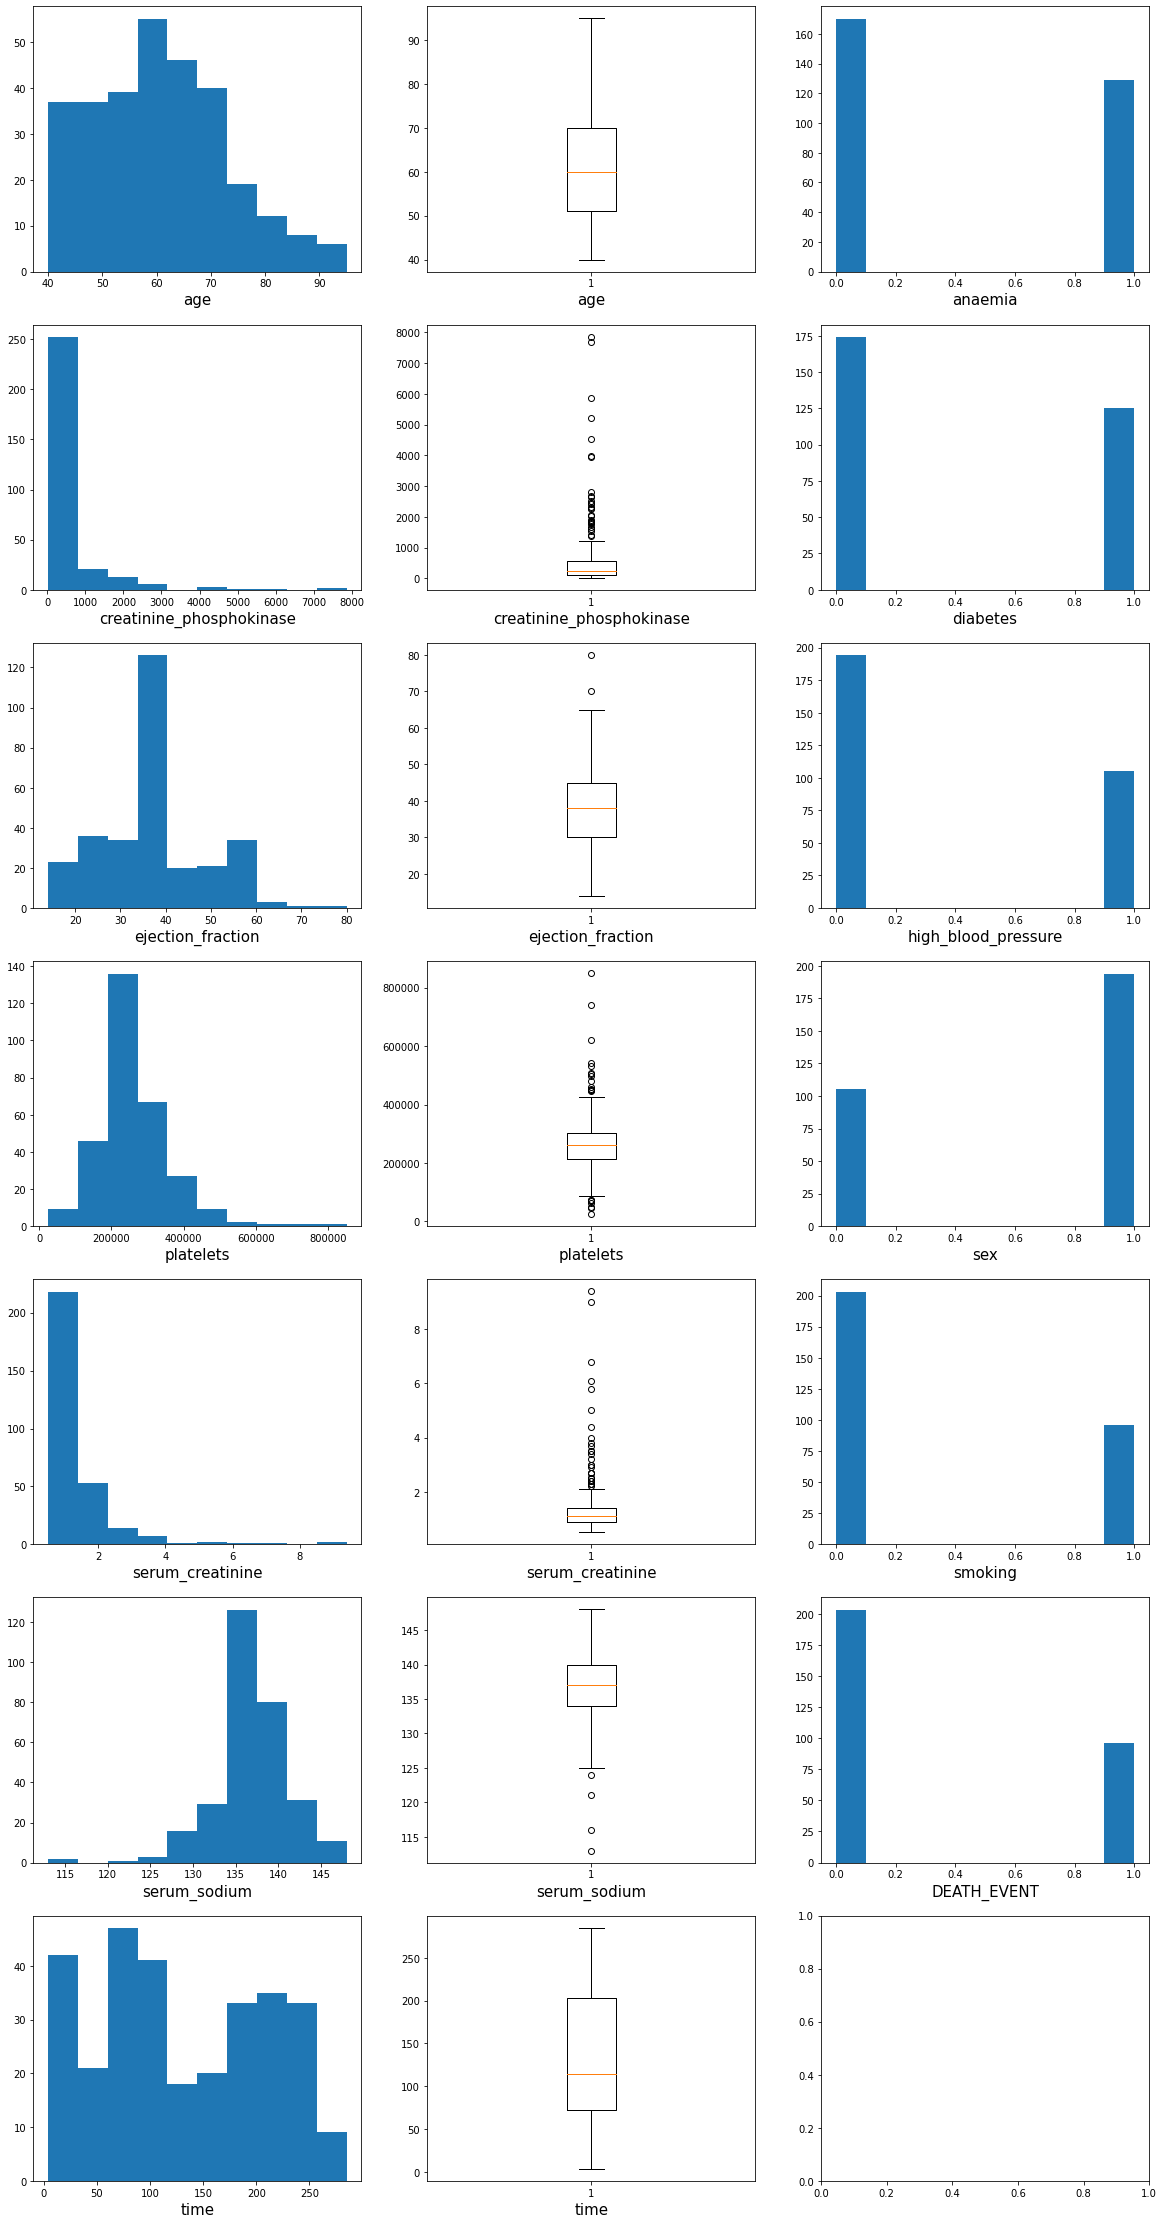

In [31]:
counter = 0
counter2 = 0
counter3 = 0
continious = []
category = []
for i in dataset:
  if dataset[i].dtype.name != 'category':
    continious.append(i)

for i in dataset:
  if dataset[i].dtype.name == 'category':
    category.append(i)

fig, ax = plt.subplots(7,3,figsize = (20,40), sharex = False, sharey = False)
for i in range(7):
  ax[i][0].hist(dataset[continious[counter]])
  ax[i][0].set_xlabel(str(continious[counter]),fontsize=15)
  counter += 1

for i in range(7):
  ax[i][1].boxplot(dataset[continious[counter2]])
  ax[i][1].set_xlabel(str(continious[counter2]),fontsize=15)
  counter2 += 1

for i in range(6):
  ax[i][2].hist(dataset[category[counter3]])
  ax[i][2].set_xlabel(str(category[counter3]),fontsize=15)
  counter3 += 1


Removing outliers could be done in terms of IQR. Removing outliers increases model accuracy but decreases F1 - score. Because target variable is fairly inbalanced and false predictions can be dangerous, value of F1 - score has bigger weight and outliers are not removed.

In [32]:
#Q1=[]
#Q3=[]
#IQR=[]

#for i, j in enumerate(continious):
#    Q1.append(dataset[j].quantile(.25))
#    Q3.append(dataset[j].quantile(.75))
#    IQR.append(Q3[i]-Q1[i])

#for i, j in enumerate(continious):
#    true_index = (dataset[j] >= (Q1[i] - 2 * IQR[i])) & (dataset[j] <=(Q3[i] + 2 * IQR[i]))
#    dataset = dataset.loc[true_index]

There is no need to further encode categorical variables since they are binary and have values of 0 or 1.

Cross tabulation with independent categorical variables vs target variable. 

In [33]:
print(pd.crosstab(dataset.DEATH_EVENT, pd.cut(x = dataset['age'], bins = 4, labels = [1,2,3,4]),normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, pd.cut(x = dataset['creatinine_phosphokinase'], bins = 4, labels = [1,2,3,4]),normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, pd.cut(x = dataset['ejection_fraction'], bins = 4, labels = [1,2,3,4]),normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, pd.cut(x = dataset['platelets'], bins = 4, labels = [1,2,3,4]),normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, pd.cut(x = dataset['serum_creatinine'], bins = 4, labels = [1,2,3,4]),normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, pd.cut(x = dataset['serum_sodium'], bins = 4, labels = [1,2,3,4]),normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, pd.cut(x = dataset['time'], bins = 4, labels = [1,2,3,4]),normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, dataset.anaemia,normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, dataset.diabetes,normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, dataset.high_blood_pressure,normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, dataset.sex,normalize = True))
print(pd.crosstab(dataset.DEATH_EVENT, dataset.smoking,normalize = True))

age                 1         2         3         4
DEATH_EVENT                                        
0            0.240803  0.294314  0.130435  0.013378
1            0.070234  0.110368  0.096990  0.043478
creatinine_phosphokinase         1         2         3         4
DEATH_EVENT                                                     
0                         0.642140  0.026756  0.010033  0.000000
1                         0.297659  0.010033  0.006689  0.006689
ejection_fraction         1         2         3         4
DEATH_EVENT                                              
0                  0.140468  0.384615  0.150502  0.003344
1                  0.170569  0.103679  0.040134  0.006689
platelets           1         2         3         4
DEATH_EVENT                                        
0            0.237458  0.411371  0.023411  0.006689
1            0.133779  0.170569  0.016722  0.000000
serum_creatinine         1         2         3         4
DEATH_EVENT                        

Correlation matrix between independent variables. Correlations are small, so they don't effect machine learning model.

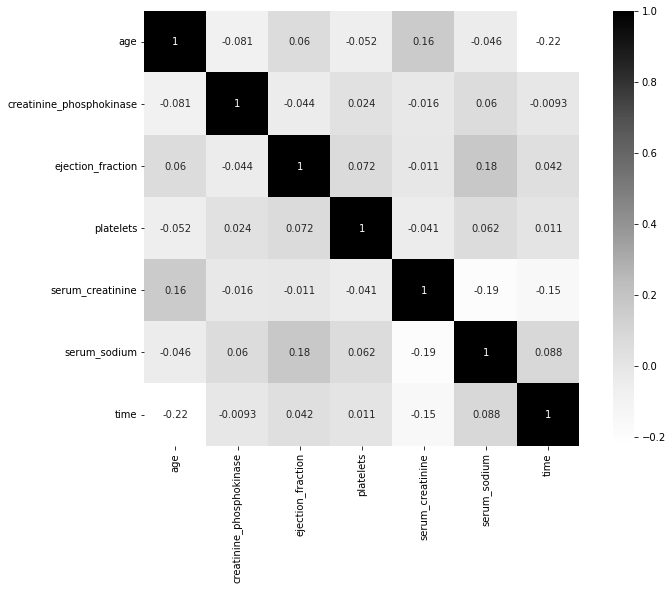

In [34]:
plt.figure(figsize=(12,8))
corr_matrix = dataset.corr()  
sns.heatmap(corr_matrix, annot=True, cmap='Greys', square=True)  
plt.show()

Splitting data to independent variables X and dependent variable y. Dependent variable is whether person has died during the follow up period or not. Variable 'time' was left out, because if model is applied to new patients data, follow-up period is unknown. That is because if patients dies during the period, period will be shorter. Shorter follow-up period predicts patient dying, so it has large effect on machine learning model. Also other than 'serum_creatinine' and 'ejection_fraction' were left out based on a tip on datasets source website. Those two variables will make more accurate prediction alone than all variables together.

In [35]:
X = dataset.iloc[:,:-2].values
y = dataset.iloc[:, -1].values
print(X)
print(y)

[[7.500e+01 0.000e+00 5.820e+02 ... 1.300e+02 1.000e+00 0.000e+00]
 [5.500e+01 0.000e+00 7.861e+03 ... 1.360e+02 1.000e+00 0.000e+00]
 [6.500e+01 0.000e+00 1.460e+02 ... 1.290e+02 1.000e+00 1.000e+00]
 ...
 [4.500e+01 0.000e+00 2.060e+03 ... 1.380e+02 0.000e+00 0.000e+00]
 [4.500e+01 0.000e+00 2.413e+03 ... 1.400e+02 1.000e+00 1.000e+00]
 [5.000e+01 0.000e+00 1.960e+02 ... 1.360e+02 1.000e+00 1.000e+00]]
[1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 0]
Length: 299
Categories (2, int64): [0, 1]


Splitting data to training and test set.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

There is no need for feature scaling with XGBoost model since it is based on decision trees which don't require feature scaling.

Training XGBoost classifier model on training set. 

In [37]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier()

Visualizing which features have biggest effect on creating the model.

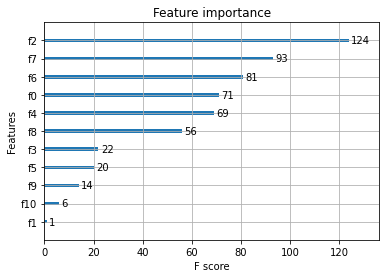

In [38]:
plot_importance(classifier)
plt.show()

For some reason barplot gives different order (right order) about imortance of features. Most important are indexes 0,4 and 7.

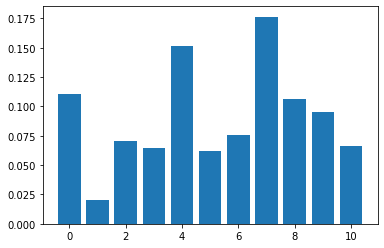

In [39]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

Evaluating which features to select when creating the model. Using accuracy and F1 score as metrics. F1 score is more imortant since target variable is inbalanced.

In [40]:
thresholds = sort(classifier.feature_importances_)
for thresh in thresholds:
  selection = SelectFromModel(classifier, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train)
  selection_model = XGBClassifier()
  selection_model.fit(select_X_train, y_train)
  select_X_test = selection.transform(X_test)
  predictions = selection_model.predict(select_X_test)
  accuracy = accuracy_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, F1 score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0, f1*100))
  

Thresh=0.020, n=11, Accuracy: 83.33%, F1 score: 61.54%
Thresh=0.062, n=10, Accuracy: 83.33%, F1 score: 61.54%
Thresh=0.064, n=9, Accuracy: 83.33%, F1 score: 64.29%
Thresh=0.066, n=8, Accuracy: 85.00%, F1 score: 64.00%
Thresh=0.071, n=7, Accuracy: 83.33%, F1 score: 58.33%
Thresh=0.076, n=6, Accuracy: 81.67%, F1 score: 59.26%
Thresh=0.095, n=5, Accuracy: 86.67%, F1 score: 69.23%
Thresh=0.106, n=4, Accuracy: 80.00%, F1 score: 60.00%
Thresh=0.111, n=3, Accuracy: 88.33%, F1 score: 74.07%
Thresh=0.152, n=2, Accuracy: 85.00%, F1 score: 66.67%
Thresh=0.176, n=1, Accuracy: 73.33%, F1 score: 20.00%


Choosing least amount of variables (3) which produce best result (variables are: 'age', 'ejection_fraction' and 'serum_creatinine'.)

In [41]:
selection = SelectFromModel(classifier, threshold=thresholds[8], prefit=True)
X_train = selection.transform(X_train)
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier()

Confusion matrix and accuracy of the model.

In [42]:
X_test = selection.transform(X_test)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[43  3]
 [ 4 10]]


0.8833333333333333

Measuring performance of model with k-Fold Cross Validation and F1 - score. Number of different test and training set splits is 10. Standard deviation is difference in results between different splits.

In [43]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('F1 - score: {:.2f} %'.format(f1_score(y_test, y_pred)*100))

Accuracy: 70.27 %
Standard Deviation: 6.41 %
F1 - score: 74.07 %


Result is fairly good. In health care one would hope for better accuracy especially in case of mortality risk.

Training ANN model with same variables as XGBoost.

In [62]:
dataset = pd.read_csv('heart_failure.csv')
X = dataset.iloc[:, [0,4,7]].values
y = dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [63]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [64]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
8/8 [==============================] - 1s 3ms/step - loss: 0.6748 - accuracy: 0.6946
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.6946
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6570 - accuracy: 0.6946
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6946
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6405 - accuracy: 0.6946
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6329 - accuracy: 0.6946
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6255 - accuracy: 0.6946
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6189 - accuracy: 0.6946
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6123 - accuracy: 0.6946
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6058 - accuracy: 0.6946
Epoch 11/100
8/8 [===========

In [65]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]]


In [66]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[34  3]
 [ 8 15]]


0.8166666666666667

In [67]:
print('F1 - score: {:.2f} %'.format(f1_score(y_test, y_pred)*100))

F1 - score: 73.17 %


Result of ANN model is close to, but not quite as good as XGBoost models.